In [84]:
# Load in our libraries
import pandas as pd
import numpy as np
import re           #import正则表达式
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

In [85]:
# Load in the train and test datasets
train = pd.read_csv('C:\\Users\\qiyex\\Anaconda3\\A_Projects_Linan\\040919\\input\\train.csv')
#为啥相对路径不行？？？
test = pd.read_csv('C:\\Users\\qiyex\\Anaconda3\\A_Projects_Linan\\040919\\input\\test.csv')

In [86]:
#Store our passenger ID for easy access
PassengerId = test['PassengerId']

In [87]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [88]:
test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [89]:
full_data = [train, test]
full_data    #list

[     PassengerId  Survived  Pclass  \
 0              1         0       3   
 1              2         1       1   
 2              3         1       3   
 3              4         1       1   
 4              5         0       3   
 5              6         0       3   
 6              7         0       1   
 7              8         0       3   
 8              9         1       3   
 9             10         1       2   
 10            11         1       3   
 11            12         1       1   
 12            13         0       3   
 13            14         0       3   
 14            15         0       3   
 15            16         1       2   
 16            17         0       3   
 17            18         1       2   
 18            19         0       3   
 19            20         1       3   
 20            21         0       2   
 21            22         1       2   
 22            23         1       3   
 23            24         1       1   
 24            25        

In [90]:
#Some feaetures of my own that I have added in
#Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

In [91]:
#Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train['Cabin'].apply(lambda x:0 if type(x) == float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x:0 if type(x)==float else 1)

In [92]:
type(train['Cabin'][2])

float

In [93]:
#Feature engineering steps taken from Sina
#Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

In [94]:
#Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1      #loc 啥意思
#在full_data里面修改，train和test里也会变化

In [95]:
#Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

In [96]:
#Remove all NULLS in the Fare column and create a new feature CategoricalFasre
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

In [97]:
train['CategoricalFare'] = pd.qcut(train['Fare'],4)           #qcut啥意思

In [98]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,CategoricalFare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,23,0,2,0,"(-0.001, 7.91]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,51,1,2,0,"(31.0, 512.329]"
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,22,0,1,1,"(7.91, 14.454]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,44,1,2,0,"(31.0, 512.329]"
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,24,0,1,1,"(7.91, 14.454]"


In [99]:
#Create a new feature categoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg-age_std,age_avg+age_std,age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)         #最后再把数据类型转换成int

In [100]:
train['Age'][np.isnan(train['Age'])].sum()      #怎么样才能看空值？

0

In [101]:
train['CategoricalAge'] = pd.cut(train['Age'],5)             #对fare的处理用了qcut，但是对年龄的处理用了cut

In [102]:
#Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search('([A-Za-z]+)\.',name)
    #if the title exists, extract and return it             #[A-Za-z]+  正则表达式，表达所有单词
    if title_search:
        return title_search.group(1)
    return ""

In [103]:
#Create a new feature Title, containing the titles of paaenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

In [104]:
#for dataset in full_data:
    #dataset.drop(columns = ['Title = data'])

In [105]:
#train = train.drop(['Title = data'],axis=1)    #没有了，列名称里面的空格也是有作用的
#df.drop(['id'], 1, inplace=True) 

In [106]:
train.head(5)   #怎么像SQL一样，看到某一列的distinct的项呢

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,CategoricalFare,CategoricalAge,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,23,0,2,0,"(-0.001, 7.91]","(16.0, 32.0]",Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,51,1,2,0,"(31.0, 512.329]","(32.0, 48.0]",Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,22,0,1,1,"(7.91, 14.454]","(16.0, 32.0]",Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,44,1,2,0,"(31.0, 512.329]","(32.0, 48.0]",Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,24,0,1,1,"(7.91, 14.454]","(32.0, 48.0]",Mr


In [107]:
#Group all non-common titles into one single grouping "RARE"     #不是，他咋知道这里面哪些是non-common 的titles啊？？？
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr','Major','Rev'
                                                'Sir','Jonkheer','Dona'],'Rare')
    dataset['Title'] = dataset['Title'].replace('Mile','Miss')
    dataset['Title'] = dataset['Title'].replace('Ms','Miss')
    dataset['Title'] = dataset['Title'].replace('Mme','Mrs')

In [108]:
for dataset in full_data:
    #Mapping Sex
    dataset['Sex'] = dataset['Sex'].map({'female':0,'male':1}).astype(int)
    
    #Mapping Titles     #两种写法，可以参考一下，一种把map的条件写在里面，一种写到外面出来了
    title_mapping = {"Mr":1,"Miss":2,"Mrs":3,"Master":4,"Rare":5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

In [109]:
for dataset in full_data:
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} )
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare']
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4
    

In [110]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,CategoricalFare,CategoricalAge,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,1,1,0,A/5 21171,0.0,NaN,0,23,0,2,0,"(-0.001, 7.91]","(16.0, 32.0]",1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,PC 17599,3.0,C85,1,51,1,2,0,"(31.0, 512.329]","(32.0, 48.0]",3.0
2,3,1,3,"Heikkinen, Miss. Laina",0,1,0,0,STON/O2. 3101282,1.0,NaN,0,22,0,1,1,"(7.91, 14.454]","(16.0, 32.0]",2.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2,1,0,113803,3.0,C123,0,44,1,2,0,"(31.0, 512.329]","(32.0, 48.0]",3.0
4,5,0,3,"Allen, Mr. William Henry",1,2,0,0,373450,1.0,NaN,0,24,0,1,1,"(7.91, 14.454]","(32.0, 48.0]",1.0


In [111]:
#Feature Selection
drop_elements = ['PassengerId','Name','Ticket','Cabin','SibSp']
train = train.drop(drop_elements, axis = 1)

In [112]:
train.head(5)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,CategoricalFare,CategoricalAge,Title
0,0,3,1,1,0,0.0,0,23,0,2,0,"(-0.001, 7.91]","(16.0, 32.0]",1.0
1,1,1,0,2,0,3.0,1,51,1,2,0,"(31.0, 512.329]","(32.0, 48.0]",3.0
2,1,3,0,1,0,1.0,0,22,0,1,1,"(7.91, 14.454]","(16.0, 32.0]",2.0
3,1,1,0,2,0,3.0,0,44,1,2,0,"(31.0, 512.329]","(32.0, 48.0]",3.0
4,0,3,1,2,0,1.0,0,24,0,1,1,"(7.91, 14.454]","(32.0, 48.0]",1.0


In [113]:
train.drop(['CategoricalAge','CategoricalFare'],axis=1)    #这样还没有真正drop掉

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0.0,0,23,0,2,0,1.0
1,1,1,0,2,0,3.0,1,51,1,2,0,3.0
2,1,3,0,1,0,1.0,0,22,0,1,1,2.0
3,1,1,0,2,0,3.0,0,44,1,2,0,3.0
4,0,3,1,2,0,1.0,0,24,0,1,1,1.0
5,0,3,1,1,0,1.0,2,16,0,1,1,1.0
6,0,1,1,3,0,3.0,0,23,1,1,1,1.0
7,0,3,1,0,1,2.0,0,30,0,5,0,4.0
8,1,3,0,1,2,1.0,0,49,0,3,0,3.0
9,1,2,0,0,0,2.0,1,35,0,2,0,3.0


In [114]:
train = train.drop(['CategoricalAge','CategoricalFare'],axis=1) 

In [115]:
test = test.drop(drop_elements,axis =1)

In [116]:
#Visualizations
#Now we have cleaned the features and extracted relevant information and dropped the categorical columns our
#feature should now all numeric, a format suitable to feed into our Machine Learning Models. However, before we 
#proceed let us generate some simple correlation and distribution plots of our trtansformed dataset to observe
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0.0,0,23,0,2,0,1.0
1,1,1,0,2,0,3.0,1,51,1,2,0,3.0
2,1,3,0,1,0,1.0,0,22,0,1,1,2.0


In [117]:
#Pearson Correlation Heatmap
#let us generate some correlation plots of the features to see how related one feature is to the next.
#To do so, we will tilize the Seaborn plotting package which allows us to plot heatmaps very 
#conveniently as follows.

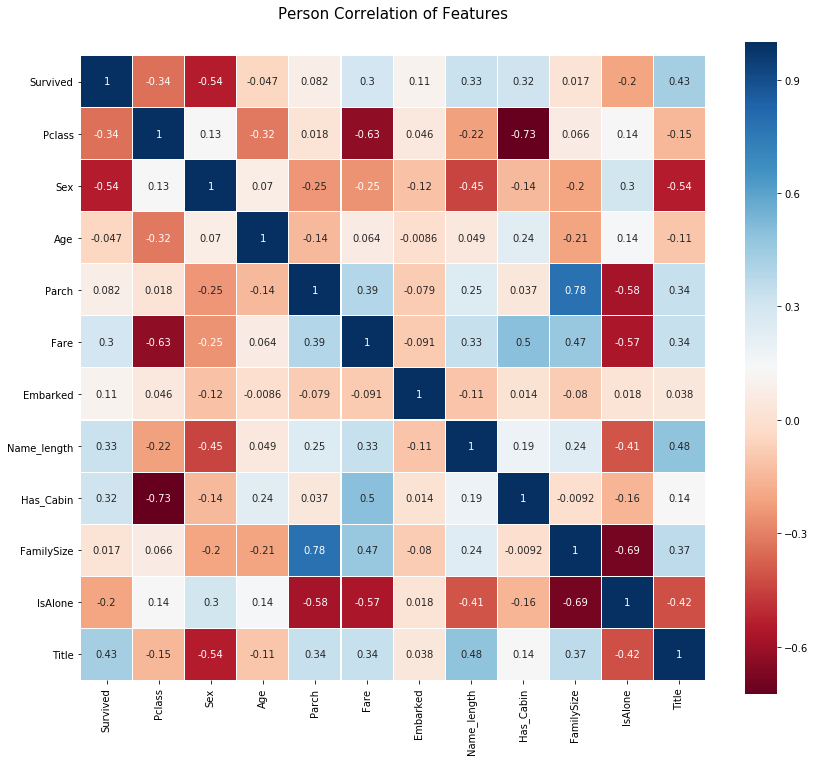

In [118]:
colormap = plt.cm.RdBu
plt.figure(figsize = (14,12))
plt.title('Person Correlation of Features',y = 1.05, size = 15)
sns.heatmap(train.astype(float).corr(),linewidths = 0.1, vmax= 1.0,square = True, 
           cmap = colormap, linecolor = 'White', annot = True)


In [119]:
#One thing that the Pearson Correlation plot can tell us is that there are not too many features strongly correlated 
#with one another.
#This is good from a point of view of feeding thse features into your learning model because this means that there isn't
#much redundant or superfluous data in our training set and we are happy that each feature carries with it some unique
#information.
#Here are two most correlated features are that of Family size and Parch (parents and Children). I'll still
#leave both features in for the purpose of this exercise.

In [120]:
#Pairplots
#Finally let us generate some pairplots to observe the distribution of data from one feature to the other
#Once again we use Seaborn to help us.

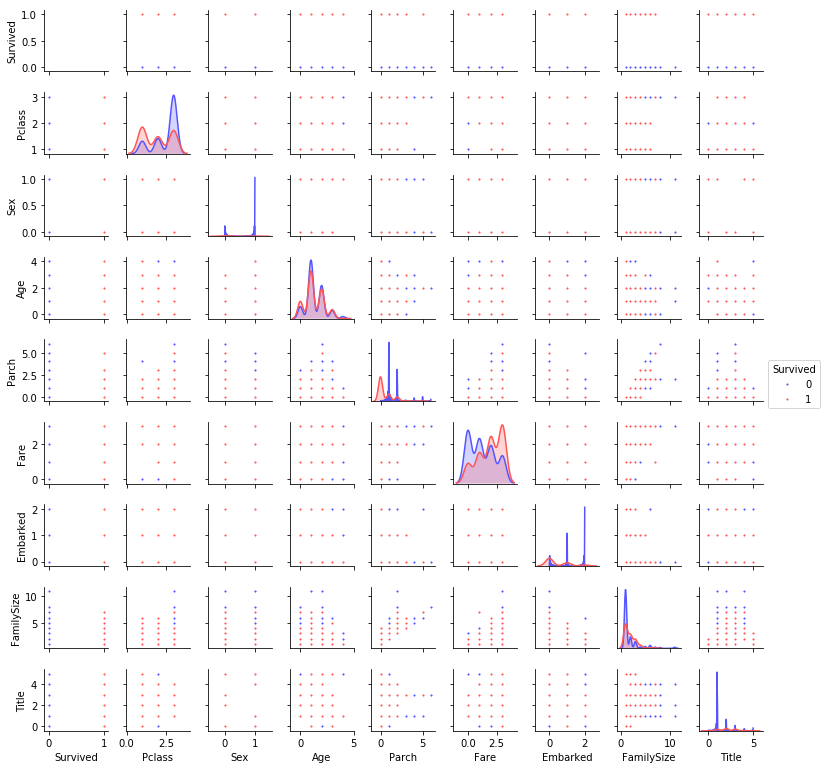

In [121]:
g = sns.pairplot(train[[u'Survived',u'Pclass',u'Sex',u'Age',u'Parch',u'Fare',u'Embarked',
                       u'FamilySize',u'Title']],hue = 'Survived',palette = 'seismic',size= 1.2,
                diag_kind = 'kde',diag_kws = dict(shade = True),plot_kws = dict(s=10))    
#diag_kws = dict(shade=True)控制阴影，plot_kws = dict(s=10))控制点的大小
#g.set(xticklabels=[])

In [122]:
#Ensembling & Stacking models
#Finally arrive at the meat and gist of this notebook

In [123]:
#Some useful parameters which will come in handy later on
ntrain = train.shape[0]        #可以看有多少列
ntest = test.shape[0]
SEED = 0 #for reproducibility
NFOLDS = 5 #set folds for out-of-fold prediction
kf = KFold(ntrain,n_folds = NFOLDS, random_state = SEED)             #????

#Class to extend the Sklearn classifier #???   clf啥意思？？？好像就是你先的classifer??
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
        
#Class to extend XGBoost classifer

In [124]:
#Out-of-Fold Predictions
"""def get_oof(clf,x_train,y_train,x_test):
    oof_train = np.zeros((ntrain,))      #????   好多看不懂
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS,ntest))
    
    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)   #？？？？
        oof_test_skf[i,:] = clf.predict(x_test)
        
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1,1), oof_test.reshape(-1,1)   #不懂啥意思
    """
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [125]:
#Generating our Base First-Level Models
#So now let usprepare five learning models as our first level classification.
#These models can all be conveniently invoked via the Sklearn libaray and are listed as follows:
#1.Random Forest classifier
#2.Extra Trees classifier
#3.AdaBoost classifier
#4.Gradient Boosting classifer
#5.Support Vector Machine

In [126]:
"""
Parameters

n_jobs: Number of cortes used for the training process. If set to -1, all cores are used
n_estimators: Number of classification trees in your learning model(set to 10 per default)
max_depth: Maximum depth of tree, or how much a node should expanded. Beware if set to too high
            a number would run the risk of overfitting as one would be growing the tree too deep
verbose: Controls whether you want to output any text during the learning process.
        A value of 0 suppresses all text while a value of 3 outputs the tree learning process at every iteration.

##please check out the full description via the offical Sklearn website. There you will find that there are a 
whole host of other useful parameters that you can play around with.##
"""


'\nParameters\n\nn_jobs: Number of cortes used for the training process. If set to -1, all cores are used\nn_estimators: Number of classification trees in your learning model(set to 10 per default)\nmax_depth: Maximum depth of tree, or how much a node should expanded. Beware if set to too high\n            a number would run the risk of overfitting as one would be growing the tree too deep\nverbose: Controls whether you want to output any text during the learning process.\n        A value of 0 suppresses all text while a value of 3 outputs the tree learning process at every iteration.\n\n##please check out the full description via the offical Sklearn website. There you will find that there are a \nwhole host of other useful parameters that you can play around with.##\n'

In [127]:
# Put in our parameters for said classifiers      #定了一些参数，但是不知道这些参数是如何选择的？？？
#Random Forest parameters
rf_params={
    'n_jobs':-1,
    'n_estimators':500,
    'warm_start':True,          #warm_start是啥意思？？？
    #'max_features':0.2,
    'max_depth':6,
    'min_samples_leaf':2,
    'max_features':'sqrt',
    'verbose':0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [128]:
"""
Furthermore, since having mentioned about Objects and classes within the OOP framework,
let us now create 5 objects that represent our 5 learning models via our Helper Sklearn Class we defined earlier.
"""

'\nFurthermore, since having mentioned about Objects and classes within the OOP framework,\nlet us now create 5 objects that represent our 5 learning models via our Helper Sklearn Class we defined earlier.\n'

In [129]:
#Create 5 objects that represent our 5 models
rf = SklearnHelper(clf = RandomForestClassifier, seed=SEED, params = rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf = AdaBoostClassifier, seed = SEED, params = ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [130]:
"""
Creating NumPy arrays out of our train and test sets
"""

'\nCreating NumPy arrays out of our train and test sets\n'

In [131]:
#Create Numpy arrays of train, test and target (Survived) dataframe to feed into our models.
y_train = train['Survived'].ravel()
train = train.drop(['Survived'],axis=1)
x_train = train.values
x_test = test.values

In [132]:
x_train

array([[3., 1., 1., ..., 2., 0., 1.],
       [1., 0., 2., ..., 2., 0., 3.],
       [3., 0., 1., ..., 1., 1., 2.],
       ...,
       [3., 0., 1., ..., 4., 0., 2.],
       [1., 1., 1., ..., 1., 1., 1.],
       [3., 1., 1., ..., 1., 1., 1.]])

In [133]:
#Output of the first level predictions
"""
We now feed the training and test data into our 5 base classifiers and use the Out-of-Fold prediction function
that we defined earlier to generate our first level predictions.
Allow a handful of minutes for the chunk of code below to run.

"""

'\nWe now feed the training and test data into our 5 base classifiers and use the Out-of-Fold prediction function\nthat we defined earlier to generate our first level predictions.\nAllow a handful of minutes for the chunk of code below to run.\n\n'

In [134]:
#Create our OOF train and test predictions. These base results will be used as new features.
#et_oof_train,et_oof_test = get_oof(et,x_train, y_train,x_test)
#训练一阶模型，并且把结果作为之后的feature
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


In [135]:
"""
Feature importances generated from the different classifiers
Now having learned our the first-level classifiers, we can utilise a very nifty feature of the Sklearn models
and that is to output the importances of the various features in the training and test sets with one very simple 
line of code.

As per the Sklearn documentation, most of the classifiers are built in with an attribute which
returns feature importances by simply typing in .featureimportances. Therefore we will invoke this very
useful attribute via our function earliand plot the feature importances as such

"""

'\nFeature importances generated from the different classifiers\nNow having learned our the first-level classifiers, we can utilise a very nifty feature of the Sklearn models\nand that is to output the importances of the various features in the training and test sets with one very simple \nline of code.\n\nAs per the Sklearn documentation, most of the classifiers are built in with an attribute which\nreturns feature importances by simply typing in .featureimportances. Therefore we will invoke this very\nuseful attribute via our function earliand plot the feature importances as such\n\n'

In [136]:
rf_feature = rf.feature_importances(x_train, y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[0.12595685 0.19100182 0.0297724  0.02189846 0.07146287 0.02409233
 0.1082859  0.06518229 0.06643636 0.01331645 0.28259427]
[0.12491766 0.39859383 0.02833181 0.01638584 0.0554898  0.02886071
 0.04756931 0.08284926 0.04389739 0.02193273 0.15117168]
[0.026 0.014 0.016 0.062 0.04  0.01  0.7   0.006 0.048 0.006 0.072]
[0.08210207 0.03542001 0.10975047 0.0263461  0.11348108 0.041673
 0.38340542 0.02098341 0.07680141 0.02687546 0.08316156]


In [137]:
"""
So I have not yet figured out how to assign and store thefeature importances outright. Therefore
I'll print out the values from the code above and then simply copy and paste into Python lists
as below(sorry for the lousy hack)
"""

"\nSo I have not yet figured out how to assign and store thefeature importances outright. Therefore\nI'll print out the values from the code above and then simply copy and paste into Python lists\nas below(sorry for the lousy hack)\n"

In [138]:
rf_features = [0.10474135,  0.21837029,  0.04432652,  0.02249159,  0.05432591,  0.02854371
  ,0.07570305,  0.01088129 , 0.24247496,  0.13685733 , 0.06128402]
et_features = [ 0.12165657,  0.37098307  ,0.03129623 , 0.01591611 , 0.05525811 , 0.028157
  ,0.04589793 , 0.02030357 , 0.17289562 , 0.04853517,  0.08910063]
ada_features = [0.028 ,   0.008  ,      0.012   ,     0.05866667,   0.032 ,       0.008
  ,0.04666667 ,  0.     ,      0.05733333,   0.73866667,   0.01066667]
gb_features = [ 0.06796144 , 0.03889349 , 0.07237845 , 0.02628645 , 0.11194395,  0.04778854
  ,0.05965792 , 0.02774745,  0.07462718,  0.4593142 ,  0.01340093]

In [139]:
#Create a dataframe from the lists containing the feature
#importance data for easy plotting via the Plotly package.

In [140]:
cols = train.columns.values
cols

array(['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked', 'Name_length',
       'Has_Cabin', 'FamilySize', 'IsAlone', 'Title'], dtype=object)

In [141]:
#Create a dataframe with features
feature_dataframe = pd.DataFrame({
    'features':cols,
    'Random Forest feature importances': rf_features,
    'Extra Trees  feature importances': et_features,
    'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
})

In [142]:
feature_dataframe

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances
0,Pclass,0.104741,0.121657,0.028000,0.067961
1,Sex,0.218370,0.370983,0.008000,0.038893
2,Age,0.044327,0.031296,0.012000,0.072378
3,Parch,0.022492,0.015916,0.058667,0.026286
4,Fare,0.054326,0.055258,0.032000,0.111944
5,Embarked,0.028544,0.028157,0.008000,0.047789
6,Name_length,0.075703,0.045898,0.046667,0.059658
7,Has_Cabin,0.010881,0.020304,0.000000,0.027747
8,FamilySize,0.242475,0.172896,0.057333,0.074627
9,IsAlone,0.136857,0.048535,0.738667,0.459314


In [143]:
"""
Interactive feature importances via Plotly scatterplots

I'll use the interactive Plotly package at this juncture to visualise the feature importances 
values of the different classifiers via a plotly scatter plot by calling "Scatter" as follows:
"""

'\nInteractive feature importances via Plotly scatterplots\n\nI\'ll use the interactive Plotly package at this juncture to visualise the feature importances \nvalues of the different classifiers via a plotly scatter plot by calling "Scatter" as follows:\n'

In [144]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [145]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [146]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')


In [147]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [148]:
#Now let us calculate the mean of all the feature importances and store it as a new column in the feature importance
#dataframe

In [149]:
#Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis=1)    #axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.104741,0.121657,0.028,0.067961,0.080590
1,Sex,0.218370,0.370983,0.008,0.038893,0.159062
2,Age,0.044327,0.031296,0.012,0.072378,0.040000


In [150]:
"""
Plotly Barplot of Average Feature Importances

Having obtained the mean feature importance across all our classifiers, 
we can plot them into a Plotly bar plot as follows:
"""

'\nPlotly Barplot of Average Feature Importances\n\nHaving obtained the mean feature importance across all our classifiers, \nwe can plot them into a Plotly bar plot as follows:\n'

In [151]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

In [152]:
"""
Second-Level Predictions from the First-level Output
First-level output as new features

Having now obtained our first-level predictions, one can think of it as essentially building a new 
set of features to be used as training data for the next classifier. As per the code below, 
we are therefore having as our new columns the first-level predictions from our earlier classifiers and 
we train the next classifier on this.
"""

'\nSecond-Level Predictions from the First-level Output\nFirst-level output as new features\n\nHaving now obtained our first-level predictions, one can think of it as essentially building a new \nset of features to be used as training data for the next classifier. As per the code below, \nwe are therefore having as our new columns the first-level predictions from our earlier classifiers and \nwe train the next classifier on this.\n'

In [153]:
base_predictions_train = pd.DataFrame({'RandomForest':rf_oof_train.ravel(),
                                       'ExtraTrees':et_oof_train.ravel(),
                                       'AdaBoost':ada_oof_train.ravel(),
                                       'GradientBoost':gb_oof_train.ravel()
                                      })
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [154]:
#Correlation Heatmap of the Second Level Training set
data = [
    go.Heatmap(
        z = base_predictions_train.astype(float).corr().values,
        x = base_predictions_train.columns.values,
        y = base_predictions_train.columns.values,
        colorscale = 'Viridis',
        showscale = True,
        reversescale = True
    )
]
py.iplot(data,filename = 'labelled-heatmap')

In [155]:
"""
There have been quite a few articles and Kaggle competition winner stories about the merits of having
trianed models that are more uncorrelated with one another producing better scores
"""

'\nThere have been quite a few articles and Kaggle competition winner stories about the merits of having\ntrianed models that are more uncorrelated with one another producing better scores\n'

In [156]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
#concatenate什么意思？？
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)


In [157]:
#Having now concatenated and joined both the first-level train and test predictions as x_train and y_train,
# We can now fit a second-level learning model.

In [158]:
"""
Second level learning model via XGBoost
Here we choose the xEtremely famous library for boosted tree learning model, XGBoost.
It was built to optimize large-scale boosted tree algorithms.
Anyway, we call an XGBClassifier and fit it to the first-level train and target data and use the learned model
to predict the test data as follows:

"""

'\nSecond level learning model via XGBoost\nHere we choose the xEtremely famous library for boosted tree learning model, XGBoost.\nIt was built to optimize large-scale boosted tree algorithms.\nAnyway, we call an XGBClassifier and fit it to the first-level train and target data and use the learned model\nto predict the test data as follows:\n\n'

In [159]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [ ]:
"""
Just a quick run down of the XGBoost parameters used in the model:
max_depth: How deep you want to grow your tree. Beware if set to too high a number might run the risk of overfitting

gamma: minimum loss reduction required to make a further partition on a leaf node of the tree.
Tha larger, the more conservative the algorithm will be.

eta: step size shrinkage used in each boosting stpe to prevent overfitting
"""

In [ ]:
"""
Producing the submission file
Finally having trained and fit all our first-level and second-level models, we can now output the predictions
into the proper format for submission to the Titanic competition as follows:
"""

In [160]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)

In [162]:
StackingSubmission.head(5)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [163]:
"""
Steps for Further Improvement
As a closing remark it must be noted that the stpes taken above just show a very simple way of producing an ensemble
stacker. You hear of ensembles created at the highest level of Kaggle competitions which involves monstrous
combination of stacked classifiers as well as levels of stacking which go to more than 2 levels.

Some additional steps that may be taken to improve one's score could be:
1. Implementing a good cross-validation strategy in training the models to find optimal parameter values
2. introduce a greater variety of base models for learning. The more uncorrelted the result, the better the final score.

"""

"\nSteps for Further Improvement\nAs a closing remark it must be noted that the stpes taken above just show a very simple way of producing an ensemble\nstacker. You hear of ensembles created at the highest level of Kaggle competitions which involves monstrous\ncombination of stacked classifiers as well as levels of stacking which go to more than 2 levels.\n\nSome additional steps that may be taken to improve one's score could be:\n1. Implementing a good cross-validation strategy in training the models to find optimal parameter values\n2. introduce a greater variety of base models for learning. The more uncorrelted the result, the better the final score.\n\n"